In [7]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

from keras.layers import Conv1D
from keras.layers import LSTM

In [8]:
movie_reviews = pd.read_csv("data/IMDB Dataset.csv")

movie_reviews.isnull().values.any()

movie_reviews.shape

(50000, 2)

In [3]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
movie_reviews["review"][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

In [5]:
import seaborn as sns

sns.countplot(x='sentiment', data=movie_reviews)

In [6]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [7]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [8]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [9]:
X[3]

'Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them '

In [10]:
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [12]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [13]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [14]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('data/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [15]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [16]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10001     
Total params: 9,264,701
Trainable params: 10,001
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [18]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 3s 108us/step - loss: 0.6042 - acc: 0.6662 - val_loss: 0.5338 - val_acc: 0.7310
Epoch 2/6
32000/32000 [==============================] - 2s 53us/step - loss: 0.5002 - acc: 0.7597 - val_loss: 0.5172 - val_acc: 0.7446
Epoch 3/6
32000/32000 [==============================] - 2s 50us/step - loss: 0.4571 - acc: 0.7883 - val_loss: 0.5282 - val_acc: 0.7400
Epoch 4/6
32000/32000 [==============================] - 2s 50us/step - loss: 0.4358 - acc: 0.8023 - val_loss: 0.5202 - val_acc: 0.7479
Epoch 5/6
32000/32000 [==============================] - 2s 51us/step - loss: 0.4252 - acc: 0.8052 - val_loss: 0.5406 - val_acc: 0.7381
Epoch 6/6
32000/32000 [==============================] - 2s 50us/step - loss: 0.4109 - acc: 0.8129 - val_loss: 0.5350 - val_acc: 0.7444


In [19]:
score = model.evaluate(X_test, y_test, verbose=1)


10000/10000 [==============================] - 0s 48us/step


In [20]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5403764594554901
Test Accuracy: 0.7422


In [22]:
from matplotlib import pyplot as plt

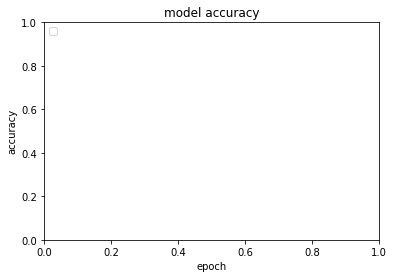

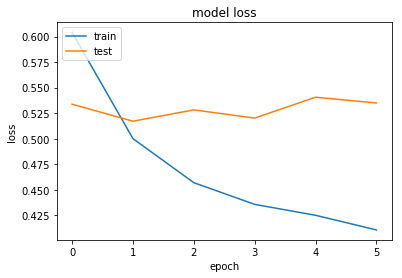

In [24]:
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [26]:
# USING CNN
# from keras.layers import Conv1D

In [27]:
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [28]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 9,318,957
Trainable params: 64,257
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [29]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 35s 1ms/step - loss: 0.4974 - acc: 0.7533 - val_loss: 0.3984 - val_acc: 0.8207
Epoch 2/6
32000/32000 [==============================] - 33s 1ms/step - loss: 0.3679 - acc: 0.8372 - val_loss: 0.3777 - val_acc: 0.8286
Epoch 3/6
32000/32000 [==============================] - 33s 1ms/step - loss: 0.3205 - acc: 0.8634 - val_loss: 0.3578 - val_acc: 0.8395
Epoch 4/6
32000/32000 [==============================] - 33s 1ms/step - loss: 0.2810 - acc: 0.8862 - val_loss: 0.3508 - val_acc: 0.8410
Epoch 5/6
32000/32000 [==============================] - 33s 1ms/step - loss: 0.2507 - acc: 0.9003 - val_loss: 0.3446 - val_acc: 0.8450
Epoch 6/6
10000/10000 [==============================] - 5s 457us/step


In [30]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.33884908294677735
Test Accuracy: 0.852


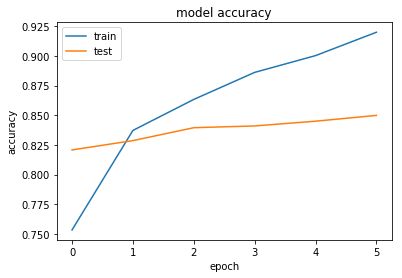

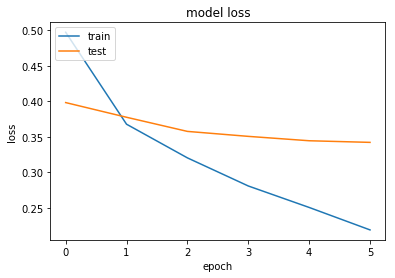

In [31]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [34]:
# USING RNN
# from keras.layers import LSTM

In [35]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [36]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 9,372,077
Trainable params: 117,377
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [37]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 87s 3ms/step - loss: 0.5426 - acc: 0.7249 - val_loss: 0.4695 - val_acc: 0.7759
Epoch 2/6
32000/32000 [==============================] - 85s 3ms/step - loss: 0.4438 - acc: 0.7914 - val_loss: 0.4144 - val_acc: 0.8103
Epoch 3/6
32000/32000 [==============================] - 87s 3ms/step - loss: 0.3959 - acc: 0.8199 - val_loss: 0.3729 - val_acc: 0.8345
Epoch 4/6
32000/32000 [==============================] - 85s 3ms/step - loss: 0.3685 - acc: 0.8355 - val_loss: 0.3557 - val_acc: 0.8405
Epoch 5/6
32000/32000 [==============================] - 86s 3ms/step - loss: 0.3473 - acc: 0.8474 - val_loss: 0.3494 - val_acc: 0.8476
Epoch 6/6
10000/10000 [==============================] - 9s 927us/step


In [38]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3466866649150848
Test Accuracy: 0.8457


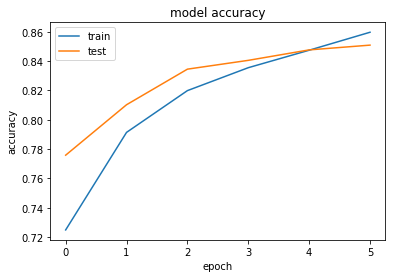

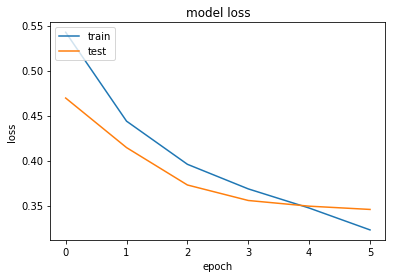

In [74]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [77]:
instance = X[57]
# instance = "I love you so much, you are brilliant, Great work, well done and it's a yes from me."
# instance = "stupid"
print(instance)

I laughed all the way through this rotten movie It so unbelievable woman leaves her husband after many years of marriage has breakdown in front of real estate office What happens The office manager comes outside and offers her job Hilarious Next thing you know the two women are going at it Yep they re lesbians Nothing rings true in this Lifetime for Women with nothing better to do movie Clunky dialogue like don want to spend the rest of my life feeling like had chance to be happy and didn take it doesn help There a wealthy distant mother who disapproves of her daughter new relationship sassy black maid unbelievable that in the year film gets made in which there a sassy black maid Hattie McDaniel must be turning in her grave The woman has husband who freaks out and wants custody of the snotty teenage kids Sheesh No cliche is left unturned 


In [78]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)

array([[0.19896638]], dtype=float32)

In [79]:
import h5py
# import hdf5

In [80]:
# serialize model to json
model_json = model.to_json()

In [82]:
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [83]:
# serialize weights to HDF5
model.save_weights("model.h5")

In [85]:
# load json and create model
json_file = open("model.json", "r")
load_model_json = json_file.read()
json_file.close()

In [86]:
from keras.models import model_from_json
loaded_model = model_from_json(load_model_json)

In [87]:
# load weights into new model
loaded_model.load_weights("model.h5")

In [88]:
loaded_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [89]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

10000/10000 [==============================] - 11s 1ms/step
Test Score: 0.3466866649150848
Test Accuracy: 0.8457


In [92]:
# instance = X[57]
instance = "I love you so much, you are brilliant, Great work, well done and it's a yes from me."
# instance = "stupid"
print(instance)

I love you so much, you are brilliant, Great work, well done and it's a yes from me.


In [93]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)

array([[0.5919773]], dtype=float32)